`Bu notebook üzerinde daha önceden kaydettiğim ts veri setlerini kullanarak modelleme, feature selection, hyperparameter tuning vb. işlemleri yapacağım.`


In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
import sklearn
sklearn._config.set_config(transform_output="pandas")

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
class StockSectorsExperiment:
    """
    Bu sınıfın amacı, otomatik preprocessing pipeline'ı oluşturmak içindir.
    """

    def __init__(self, scaler_name: str = None, imputer_name: str = None):
        self.target = "Sector"
        self.create_pipeline(scaler_name=scaler_name,
                             imputer_name=imputer_name)
        self.target_encoder = {
            "Finance": 0,
            "Technology": 1,
            "Healthcare": 2
        }

    def scaler(self, name: str = None):
        if name == "StandardScaler":
            from sklearn.preprocessing import StandardScaler
            return StandardScaler()
        elif name == "MinMaxScaler":
            from sklearn.preprocessing import MinMaxScaler
            return MinMaxScaler()
        elif name == "RobustScaler":
            from sklearn.preprocessing import RobustScaler
            return RobustScaler()
        elif name is None:
            return None
        else:
            raise ValueError(
                "Lütfen geçerli bir scaler adı girin. (StandardScaler, MinMaxScaler, RobustScaler)")

    def imputer(self, name: str = None):
        if name == "DropImputer":
            from feature_engine.imputation import DropMissingData
            return DropMissingData()
        elif name == "MeanImputer":
            from feature_engine.imputation import MeanMedianImputer
            return MeanMedianImputer(imputation_method="mean")
        elif name == "MedianImputer":
            from feature_engine.imputation import MeanMedianImputer
            return MeanMedianImputer(imputation_method="median")
        elif name is None:
            return None
        else:
            raise ValueError(
                "Lütfen geçerli bir imputer adı girin. (SimpleImputer)")

    def create_pipeline(self, scaler_name: str = None, imputer_name: str = None):
        from sklearn.pipeline import Pipeline
        try:
            scaler = self.scaler(name=scaler_name)
            imputer = self.imputer(name=imputer_name)
        except ValueError as e:
            raise ValueError("Scaler veya imputer adı geçersiz.") from e
        if scaler is None and imputer is None:
            self.pipeline = None
        elif scaler is None:
            self.pipeline = Pipeline([
                (f"{imputer_name}_Imputer", imputer)
            ])
        elif imputer is None:
            self.pipeline = Pipeline([
                (f"{scaler_name}_Scaler", scaler)
            ])
        else:
            self.pipeline = Pipeline([
                (f"{imputer_name}_Imputer", imputer),
                (f"{scaler_name}_Scaler", scaler)
            ])

In [21]:
df = pd.read_csv("data/stock_sectors/feature_data.csv")

In [22]:
df.head()

,Unnamed: 0,Change__variance_larger_than_standard_deviation,Change__has_duplicate_max,Change__has_duplicate_min,Change__has_duplicate,Change__sum_values,Change__abs_energy,Change__mean_abs_change,Change__mean_change,Change__mean_second_derivative_central,...,Change__fourier_entropy__bins_10,Change__fourier_entropy__bins_100,Change__permutation_entropy__dimension_3__tau_1,Change__permutation_entropy__dimension_4__tau_1,Change__permutation_entropy__dimension_5__tau_1,Change__permutation_entropy__dimension_6__tau_1,Change__permutation_entropy__dimension_7__tau_1,Change__query_similarity_count__query_None__threshold_0.0,Change__mean_n_absolute_max__number_of_maxima_7,Sector
0,A,0.0,0.0,0.0,0.0,239.617950,254.500594,0.089047,0.000663,-0.000055,...,0.896160,2.572932,1.731155,2.938077,4.114603,4.945395,5.297911,NaN,1.353611,Healthcare
1,AACI,0.0,0.0,1.0,1.0,28.448906,28.910768,0.005414,0.004534,-0.000051,...,0.099050,0.297538,0.435308,0.600616,0.663709,0.700324,0.709112,NaN,1.036252,Finance
2,AACT,0.0,0.0,1.0,1.0,9.119632,9.240944,0.004504,0.004404,-0.000006,...,0.099050,0.099050,0.154389,0.191539,0.226642,0.227488,0.228342,NaN,1.014327,Finance
3,AADI,0.0,0.0,1.0,1.0,67.864867,72.452853,0.078256,0.003946,-0.000307,...,0.185847,0.556229,0.952653,1.422217,1.768363,1.904773,1.942552,NaN,1.756573,Healthcare
4,AAMC,0.0,0.0,1.0,1.0,29.805295,53.391893,0.046842,0.003093,0.000272,...,0.099050,0.301687,0.299361,0.388132,0.468991,0.547763,0.612348,NaN,2.344726,Finance


In [23]:
df.rename(columns={"Unnamed: 0": "Symbol"}, inplace=True)
# Özel karakterleri alt çizgiyle değiştirme
df.columns = df.columns.str.replace('[^a-zA-Z0-9_]', '_')

In [24]:
df.isnull().sum().sort_values(ascending=False)

Change__query_similarity_count__query_None__threshold_0.0    3009
Change__friedrich_coefficients__coeff_1__m_3__r_30           2084
Change__max_langevin_fixed_point__m_3__r_30                  2084
Change__friedrich_coefficients__coeff_0__m_3__r_30           2084
Change__friedrich_coefficients__coeff_2__m_3__r_30           2084
                                                             ... 
Change__fft_coefficient__attr_"real"__coeff_16                  0
Change__fft_coefficient__attr_"real"__coeff_17                  0
Change__fft_coefficient__attr_"real"__coeff_18                  0
Change__fft_coefficient__attr_"real"__coeff_19                  0
Sector                                                          0
Length: 779, dtype: int64

Verisetinin yarısından fazlası boş olan feature'ları kullanmak yerine, bu feature'ları çıkartmak daha mantıklı olacaktır.


In [25]:
def drop_missing_features(df: pd.DataFrame, threshold: float = 0.5) -> pd.DataFrame:
    df = df.copy()
    missing_values = df.isnull().mean()
    return df.drop(missing_values[missing_values > threshold].index, axis=1)

In [26]:
df = drop_missing_features(df)

`Görüldüğü gibi bu değerler çıkartıldı.`


In [27]:
df.isnull().sum().sort_values(ascending=False)

Change__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"      31
Change__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"    31
Change__partial_autocorrelation__lag_8                             19
Change__autocorrelation__lag_3                                     19
Change__autocorrelation__lag_9                                     19
                                                                   ..
Change__fft_coefficient__attr_"real"__coeff_14                      0
Change__fft_coefficient__attr_"real"__coeff_15                      0
Change__fft_coefficient__attr_"real"__coeff_16                      0
Change__fft_coefficient__attr_"real"__coeff_17                      0
Sector                                                              0
Length: 773, dtype: int64

Şimdi, yukarıda yazdığımız sınıfı kullanarak örnek bir preprocessing pipeline kurup verilerimiz üzerinde deneyelim.


In [28]:
example_prep_exp = StockSectorsExperiment(
    scaler_name="RobustScaler", imputer_name="DropImputer")

In [29]:
example_prep_exp.pipeline

Pipeline(steps=[('DropImputer_Imputer', DropMissingData()),
                ('RobustScaler_Scaler', RobustScaler())])

In [30]:
X = df.drop(columns=[example_prep_exp.target, "Symbol"])
y = df[example_prep_exp.target]

In [31]:
y = y.map(example_prep_exp.target_encoder)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [33]:
X_train_prepared = example_prep_exp.pipeline.fit_transform(X_train)
X_test_prepared = example_prep_exp.pipeline.transform(X_test)

In [34]:
y_train_prepared = y_train[y_train.index.isin(X_train_prepared.index)]
y_test_prepared = y_test[y_test.index.isin(X_test_prepared.index)]

In [20]:
model = LGBMClassifier()

In [57]:
model.fit(X_train_prepared, y_train_prepared)

LGBMClassifier()

In [58]:
pred = model.predict(X_test_prepared)
pred_proba = model.predict_proba(X_test_prepared)

In [59]:
def classification_metrics(y_true, y_pred, y_pred_proba):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="macro"),
        "precision": precision_score(y_true, y_pred, average="macro"),
        "recall": recall_score(y_true, y_pred, average="macro"),
        "roc_auc": roc_auc_score(y_true, y_pred_proba, average="macro", multi_class="ovr")
    }

In [60]:
train_pred = model.predict(X_train_prepared)
train_pred_proba = model.predict_proba(X_train_prepared)

In [61]:
classification_metrics(y_train_prepared, train_pred, train_pred_proba)

{'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0, 'recall': 1.0, 'roc_auc': 1.0}

In [62]:
classification_metrics(y_test_prepared, pred, pred_proba)

{'accuracy': 0.715008431703204,
 'f1': 0.6888562399735584,
 'precision': 0.7166606273732986,
 'recall': 0.6887873645738155,
 'roc_auc': 0.8778760022019888}

In [36]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier()

ada_model.fit(X_train_prepared, y_train_prepared)

train_accuracy_ada = ada_model.score(X_train_prepared, y_train_prepared)
test_accuracy_ada = ada_model.score(X_test_prepared, y_test_prepared)

print("Eğitim verileri doğruluk oranı:", train_accuracy_ada)
print("Test verileri doğruluk oranı:", test_accuracy_ada)

Eğitim verileri doğruluk oranı: 0.7302852348993288
Test verileri doğruluk oranı: 0.6599326599326599


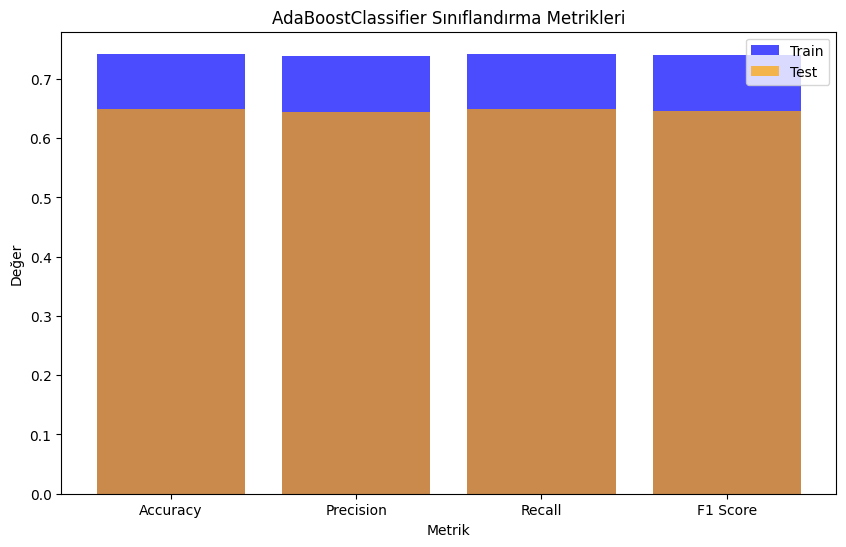

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_train_pred_ada = ada_model.predict(X_train_prepared)
y_test_pred_ada = ada_model.predict(X_test_prepared)

train_accuracy_ada = accuracy_score(y_train_prepared, y_train_pred_ada)
test_accuracy_ada = accuracy_score(y_test_prepared, y_test_pred_ada)

train_precision_ada = precision_score(
    y_train_prepared, y_train_pred_ada, average='weighted')
test_precision_ada = precision_score(
    y_test_prepared, y_test_pred_ada, average='weighted')

train_recall_ada = recall_score(
    y_train_prepared, y_train_pred_ada, average='weighted')
test_recall_ada = recall_score(
    y_test_prepared, y_test_pred_ada, average='weighted')

train_f1_score_ada = f1_score(
    y_train_prepared, y_train_pred_ada, average='weighted')
test_f1_score_ada = f1_score(
    y_test_prepared, y_test_pred_ada, average='weighted')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_scores_ada = [train_accuracy_ada,
                    train_precision_ada, train_recall_ada, train_f1_score_ada]
test_scores_ada = [test_accuracy_ada, test_precision_ada,
                   test_recall_ada, test_f1_score_ada]

plt.figure(figsize=(10, 6))
plt.bar(metrics, train_scores_ada, color='blue', alpha=0.7, label='Train')
plt.bar(metrics, test_scores_ada, color='orange', alpha=0.7, label='Test')
plt.title('AdaBoostClassifier Sınıflandırma Metrikleri')
plt.xlabel('Metrik')
plt.ylabel('Değer')
plt.legend()
plt.show()

In [63]:
print("Ada Boost verileri için Classification Report:")
print(classification_report(y_test_prepared, y_test_pred_ada))

Ada Boost verileri için Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       195
           1       0.51      0.47      0.49       163
           2       0.69      0.67      0.68       235

    accuracy                           0.65       593
   macro avg       0.63      0.64      0.64       593
weighted avg       0.65      0.65      0.65       593



In [54]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_prepared, y_train_prepared)

# Eğitim ve test doğruluk oranlarını hesaplama
train_accuracy_rf = rf_model.score(X_train_prepared, y_train_prepared)
test_accuracy_rf = rf_model.score(X_test_prepared, y_test_prepared)

print("Random Forest Eğitim verileri doğruluk oranı:", train_accuracy_rf)
print("Random Forest Test verileri doğruluk oranı:", test_accuracy_rf)

Random Forest Eğitim verileri doğruluk oranı: 1.0
Random Forest Test verileri doğruluk oranı: 0.6644182124789207


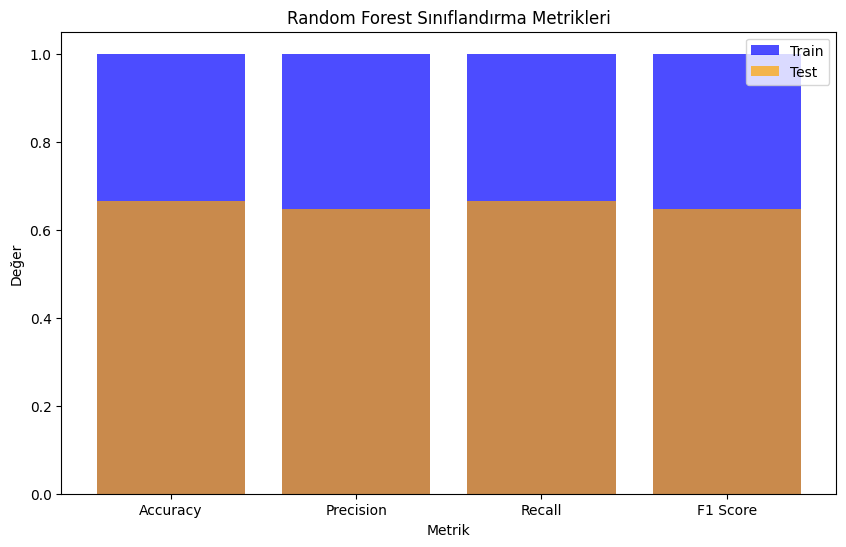

In [55]:
y_train_pred_rf = rf_model.predict(X_train_prepared)
y_test_pred_rf = rf_model.predict(X_test_prepared)

train_accuracy_rf = accuracy_score(y_train_prepared, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test_prepared, y_test_pred_rf)

train_precision_rf = precision_score(
    y_train_prepared, y_train_pred_rf, average='weighted')
test_precision_rf = precision_score(
    y_test_prepared, y_test_pred_rf, average='weighted')

train_recall_rf = recall_score(
    y_train_prepared, y_train_pred_rf, average='weighted')
test_recall_rf = recall_score(
    y_test_prepared, y_test_pred_rf, average='weighted')

train_f1_score_rf = f1_score(
    y_train_prepared, y_train_pred_rf, average='weighted')
test_f1_score_rf = f1_score(
    y_test_prepared, y_test_pred_rf, average='weighted')

metrics_rf = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_scores_rf = [train_accuracy_rf, train_precision_rf,
                   train_recall_rf, train_f1_score_rf]
test_scores_rf = [test_accuracy_rf, test_precision_rf,
                  test_recall_rf, test_f1_score_rf]

plt.figure(figsize=(10, 6))
plt.bar(metrics_rf, train_scores_rf, color='blue', alpha=0.7, label='Train')
plt.bar(metrics_rf, test_scores_rf, color='orange', alpha=0.7, label='Test')
plt.title('Random Forest Sınıflandırma Metrikleri')
plt.xlabel('Metrik')
plt.ylabel('Değer')
plt.legend()
plt.show()

In [62]:
print("Random Forest Test Verileri için Classification Report:")
print(classification_report(y_test_prepared, y_test_pred_rf))

Random Forest Test Verileri için Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       195
           1       0.52      0.31      0.39       163
           2       0.65      0.80      0.72       235

    accuracy                           0.66       593
   macro avg       0.64      0.64      0.63       593
weighted avg       0.65      0.66      0.65       593



In [29]:
svc_model = SVC()
svc_model.fit(X_train_prepared, y_train_prepared)
train_accuracy = svc_model.score(X_train_prepared, y_train_prepared)
test_accuracy = svc_model.score(X_test_prepared, y_test_prepared)
svc_predictions_train = svc_model.predict(X_train_prepared)
svc_predictions_test = svc_model.predict(X_test_prepared)

print("Eğitim verileri doğruluk oranı:", train_accuracy)
print("Test verileri doğruluk oranı:", test_accuracy)

Eğitim verileri doğruluk oranı: 0.4087468460891506
Test verileri doğruluk oranı: 0.3962900505902192


In [30]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train_prepared, y_train_prepared)
train_accuracy = logistic_model.score(X_train_prepared, y_train_prepared)
test_accuracy = logistic_model.score(X_test_prepared, y_test_prepared)
lr_predictions_train = logistic_model.predict(X_train_prepared)
lr_predictions_test = logistic_model.predict(X_test_prepared)

print("Eğitim verileri doğruluk oranı:", train_accuracy)
print("Test verileri doğruluk oranı:", test_accuracy)

Eğitim verileri doğruluk oranı: 0.511354079058032
Test verileri doğruluk oranı: 0.5025295109612141


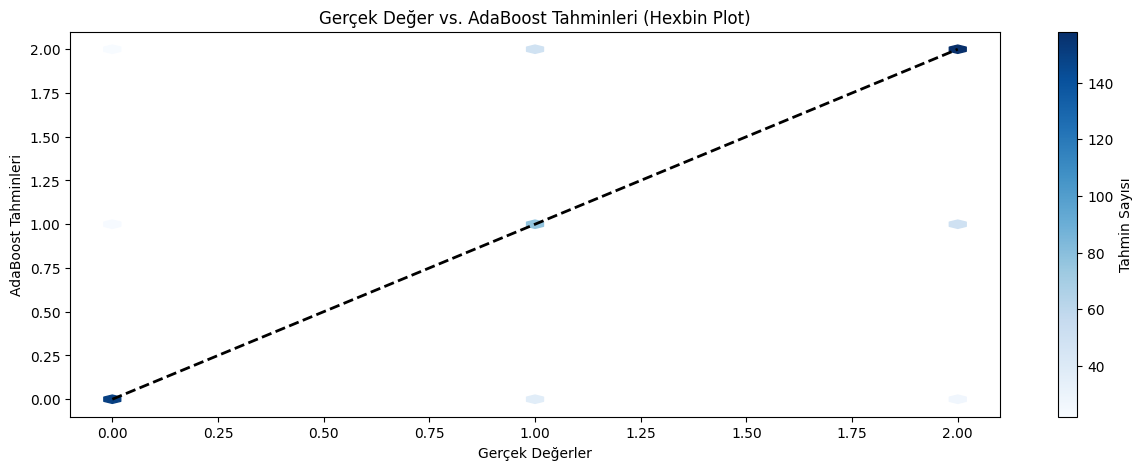

In [45]:
ada_predictions_test = ada_model.predict(X_test_prepared)

# Hexbin plot
plt.figure(figsize=(15, 5))
plt.hexbin(y_test_prepared, ada_predictions_test,
           gridsize=50, cmap='Blues', mincnt=1)
plt.colorbar(label='Tahmin Sayısı')
plt.plot([min(y_test_prepared), max(y_test_prepared)], [
         min(y_test_prepared), max(y_test_prepared)], 'k--', lw=2)
plt.xlabel('Gerçek Değerler')
plt.ylabel('AdaBoost Tahminleri')
plt.title('Gerçek Değer vs. AdaBoost Tahminleri (Hexbin Plot)')
plt.show()

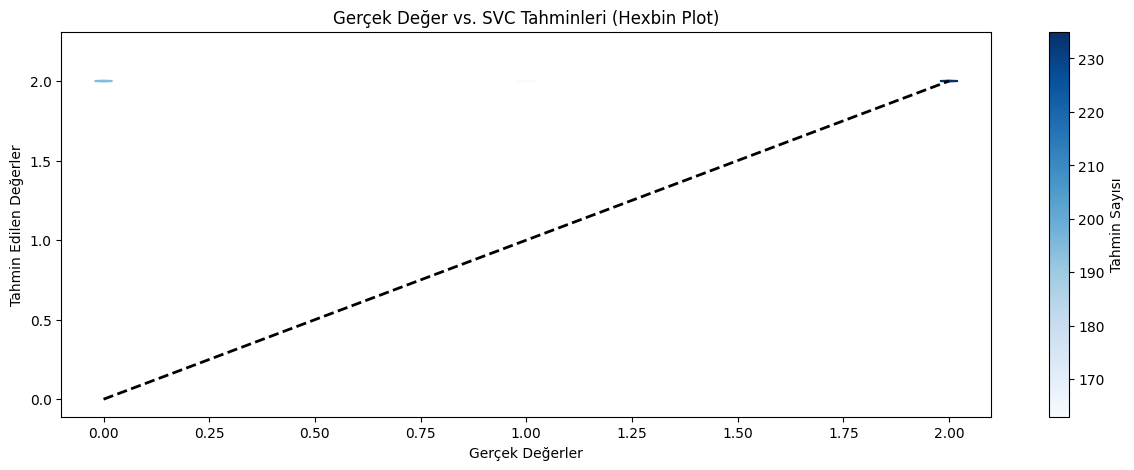

In [44]:
plt.figure(figsize=(15, 5))
plt.hexbin(y_test_prepared, svc_predictions_test,
           gridsize=50, cmap='Blues', mincnt=1)
plt.colorbar(label='Tahmin Sayısı')
plt.plot([min(y_test_prepared), max(y_test_prepared)], [
         min(y_test_prepared), max(y_test_prepared)], 'k--', lw=2)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.title('Gerçek Değer vs. SVC Tahminleri (Hexbin Plot)')
plt.show()

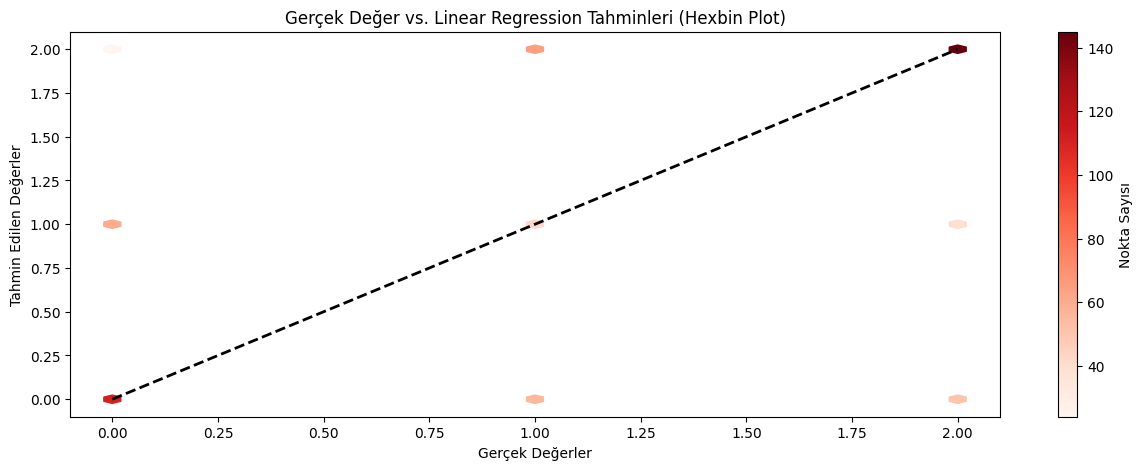

In [43]:
plt.figure(figsize=(15, 5))
plt.hexbin(y_test_prepared, lr_predictions_test,
           gridsize=50, cmap='Reds', mincnt=1)
plt.colorbar(label='tahmin sayısı')
plt.plot([min(y_test_prepared), max(y_test_prepared)], [
         min(y_test_prepared), max(y_test_prepared)], 'k--', lw=2)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.title('Gerçek Değer vs. Linear Regression Tahminleri (Hexbin Plot)')
plt.show()

In [64]:
from xgboost import XGBClassifier
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

xgb_model = XGBClassifier()

xgb_model.fit(X_train_prepared, y_train_prepared)

y_pred_xgb = xgb_model.predict(X_test_prepared)
accuracy = accuracy_score(y_test_prepared, y_pred_xgb)
f1 = f1_score(y_test_prepared, y_pred_xgb, average='weighted')

print("XGBoost modeli ile elde edilen doğruluk:", accuracy)
print("XGBoost modeli ile elde edilen F1 skoru:", f1)

XGBoost modeli ile elde edilen doğruluk: 0.7065767284991569
XGBoost modeli ile elde edilen F1 skoru: 0.6962840461904113


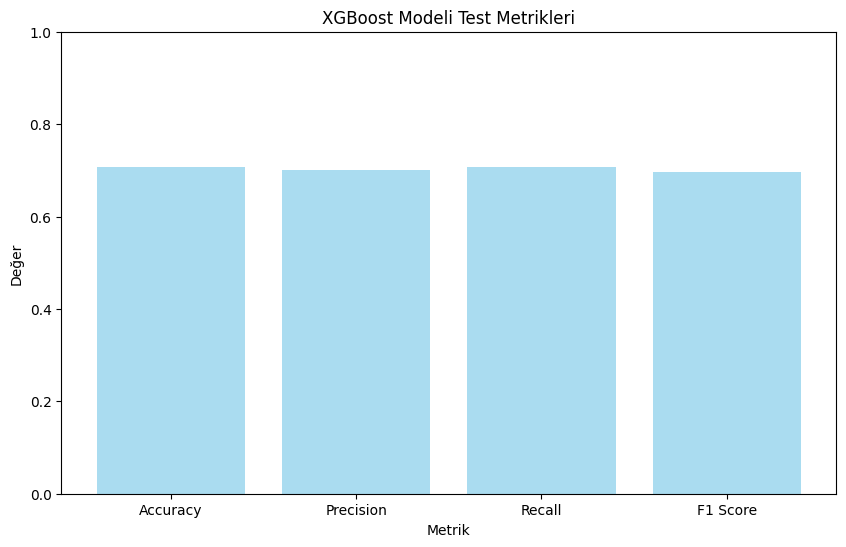

In [67]:
accuracy = accuracy_score(y_test_prepared, y_pred_xgb)
precision = precision_score(y_test_prepared, y_pred_xgb, average='weighted')
recall = recall_score(y_test_prepared, y_pred_xgb, average='weighted')
f1 = f1_score(y_test_prepared, y_pred_xgb, average='weighted')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metric_values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 6))
plt.bar(metrics, metric_values, color='skyblue', alpha=0.7)
plt.title('XGBoost Modeli Test Metrikleri')
plt.xlabel('Metrik')
plt.ylabel('Değer')
plt.ylim(0, 1)  # Metrik değerlerinin aralığını 0-1 olarak ayarlama
plt.show()

In [66]:
print("XGBoost modeli için Classification Report:")
print(classification_report(y_test_prepared, y_pred_xgb))

XGBoost modeli için Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       195
           1       0.59      0.42      0.49       163
           2       0.68      0.83      0.75       235

    accuracy                           0.71       593
   macro avg       0.70      0.68      0.68       593
weighted avg       0.70      0.71      0.70       593



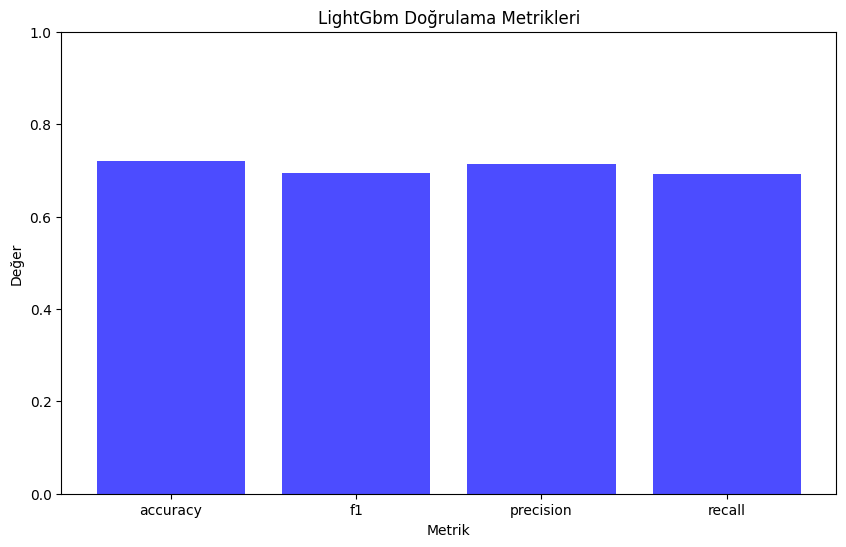

In [69]:
metrics = {'accuracy': 0.7195945945945946,
           'f1': 0.693521260412687,
           'precision': 0.7131015589618775,
           'recall': 0.6924765091570672,
           }

metric_names = list(metrics.keys())
metric_values = list(metrics.values())

plt.figure(figsize=(10, 6))
plt.bar(metric_names, metric_values, color='blue', alpha=0.7)
plt.title('LightGbm Doğrulama Metrikleri')
plt.xlabel('Metrik')
plt.ylabel('Değer')
plt.ylim(0, 1)
plt.show()

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

X_train_array = X_train_prepared.values
X_test_array = X_test_prepared.values

X_train_reshaped = X_train_array.reshape(
    (X_train_array.shape[0], 1, X_train_array.shape[1]))
X_test_reshaped = X_test_array.reshape(
    (X_test_array.shape[0], 1, X_test_array.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, input_shape=(
    X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(Dense(units=3, activation='softmax'))

lstm_model.compile(
    optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lstm_model.fit(X_train_reshaped, y_train_prepared, epochs=10,
               batch_size=32, validation_data=(X_test_reshaped, y_test_prepared))

train_loss, train_accuracy = lstm_model.evaluate(
    X_train_reshaped, y_train_prepared, verbose=0)
test_loss, test_accuracy = lstm_model.evaluate(
    X_test_reshaped, y_test_prepared, verbose=0)

print("Eğitim verileri kayıp ve doğruluk oranı:", train_loss, train_accuracy)
print("Test verileri kayıp ve doğruluk oranı:", test_loss, test_accuracy)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4907 - loss: 1.0023 - val_accuracy: 0.5987 - val_loss: 0.8576
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6494 - loss: 0.7666 - val_accuracy: 0.6071 - val_loss: 0.8107
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7339 - loss: 0.6467 - val_accuracy: 0.6088 - val_loss: 0.8120
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7681 - loss: 0.5579 - val_accuracy: 0.6155 - val_loss: 0.8092
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7884 - loss: 0.5150 - val_accuracy: 0.6071 - val_loss: 0.8162
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7943 - loss: 0.4698 - val_accuracy: 0.6223 - val_loss: 0.8244
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8273 - loss: 0.4284 - val_accuracy: 0.6155 - val_loss: 0.8395
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8500 - loss: 0.3862 - val_accuracy: 0.6223 - val_loss:

In [21]:
ann_model = Sequential()
ann_model.add(Dense(units=64, activation='relu',
              input_dim=X_train_prepared.shape[1]))  # Giriş katmanı
ann_model.add(Dense(units=32, activation='relu'))  # Gizli katman
ann_model.add(Dense(units=3, activation='softmax'))  # Çıkış katmanı

ann_model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann_model.fit(X_train_prepared, y_train_prepared, epochs=10,
              batch_size=32, validation_data=(X_test_prepared, y_test_prepared))

train_loss_ann, train_accuracy_ann = ann_model.evaluate(
    X_train_prepared, y_train_prepared, verbose=0)
test_loss_ann, test_accuracy_ann = ann_model.evaluate(
    X_test_prepared, y_test_prepared, verbose=0)

print("Eğitim verileri kayıp ve doğruluk oranı:",
      train_loss_ann, train_accuracy_ann)
print("Test verileri kayıp ve doğruluk oranı_ann:", test_loss, test_accuracy_ann)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4672 - loss: 103.8418 - val_accuracy: 0.6239 - val_loss: 1.4754
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6243 - loss: 2007.8406 - val_accuracy: 0.5767 - val_loss: 1.5134
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6799 - loss: 34.1006 - val_accuracy: 0.5885 - val_loss: 1.7118
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6714 - loss: 47.8310 - val_accuracy: 0.6324 - val_loss: 1.6521
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7239 - loss: 23.8942 - val_accuracy: 0.6358 - val_loss: 1.4069
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7662 - loss: 9.8779 - val_accuracy: 0.5902 - val_loss: 3.3356
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7187 - loss: 22.2107 - val_accuracy: 0.6256 - val_loss: 1.5071
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7560 - loss: 15.6804 - val_accuracy: 0.6476 -

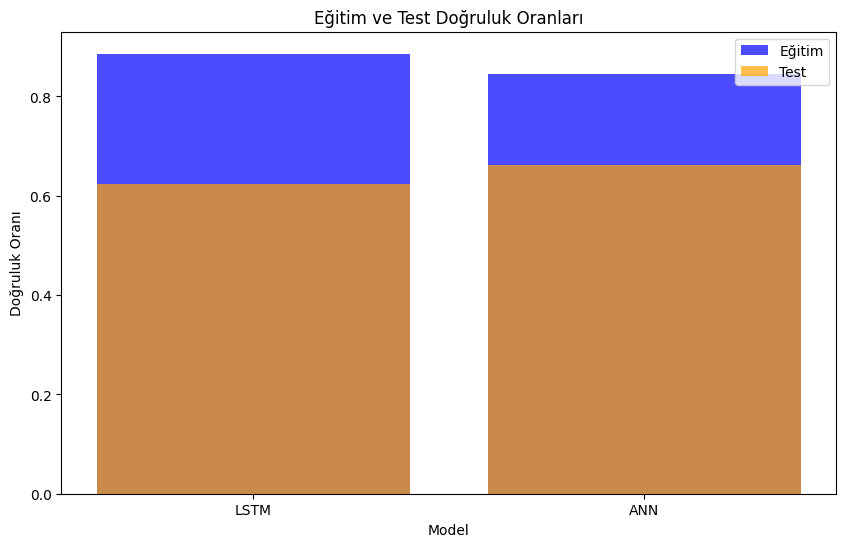

In [22]:
train_accuracies = [train_accuracy, train_accuracy_ann]
test_accuracies = [test_accuracy, test_accuracy_ann]

# Model isimleri
models = ['LSTM', 'ANN']

# Grafik oluşturma
plt.figure(figsize=(10, 6))
plt.bar(models, train_accuracies, color='blue', alpha=0.7, label='Eğitim')
plt.bar(models, test_accuracies, color='orange', alpha=0.7, label='Test')
plt.title('Eğitim ve Test Doğruluk Oranları')
plt.xlabel('Model')
plt.ylabel('Doğruluk Oranı')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

# LSTM modeli tahminleri
lstm_predictions = lstm_model.predict(X_test_reshaped)
lstm_predictions = np.argmax(lstm_predictions, axis=1)

# ANN modeli tahminleri
ann_predictions = ann_model.predict(X_test_prepared)
ann_predictions = np.argmax(ann_predictions, axis=1)
# Confusion matrix
lstm_cm = confusion_matrix(y_test_prepared, lstm_predictions)
ann_cm = confusion_matrix(y_test_prepared, ann_predictions)

# Classification report
lstm_report = classification_report(y_test_prepared, lstm_predictions)
ann_report = classification_report(y_test_prepared, ann_predictions)

print("LSTM Confusion Matrix:")
print(lstm_cm)
print("\nLSTM Classification Report:")
print(lstm_report)

print("\nANN Confusion Matrix:")
print(ann_cm)
print("\nANN Classification Report:")
print(ann_report)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
LSTM Confusion Matrix:
[[159  13  23]
 [ 38  64  61]
 [ 24  64 147]]

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.76       195
           1       0.45      0.39      0.42       163
           2       0.64      0.63      0.63       235

    accuracy                           0.62       593
   macro avg       0.60      0.61      0.61       593
weighted avg       0.61      0.62      0.62       593


ANN Confusion Matrix:
[[149  21  25]
 [ 35  68  60]
 [ 24  35 176]]

ANN Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       195
           1       0.55      0.42      0.47       163
           2       0.67      0.75      0.71       235

    accuracy                           0.66       593
   macro avg       0.65      0.64      0.64       593
weighted avg       

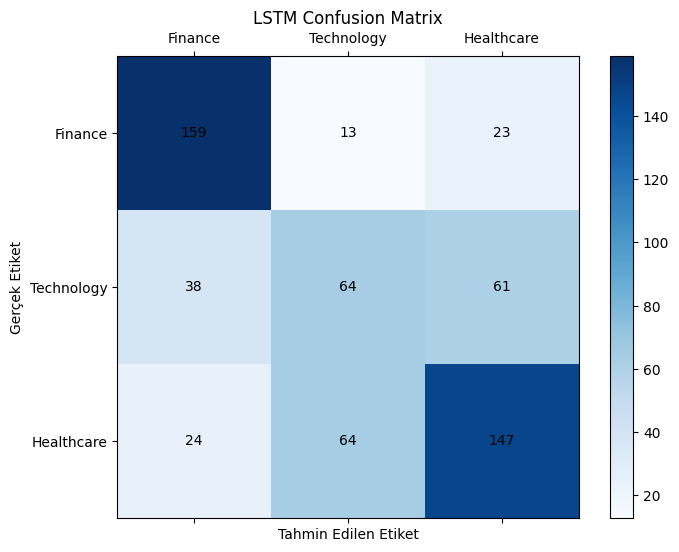

In [34]:
labels = ['Finance', 'Technology', 'Healthcare']

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(lstm_cm, cmap='Blues')

plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        c = lstm_cm[j, i]
        ax.text(i, j, str(c), va='center', ha='center')

plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('LSTM Confusion Matrix')
plt.colorbar(cax)

plt.show()

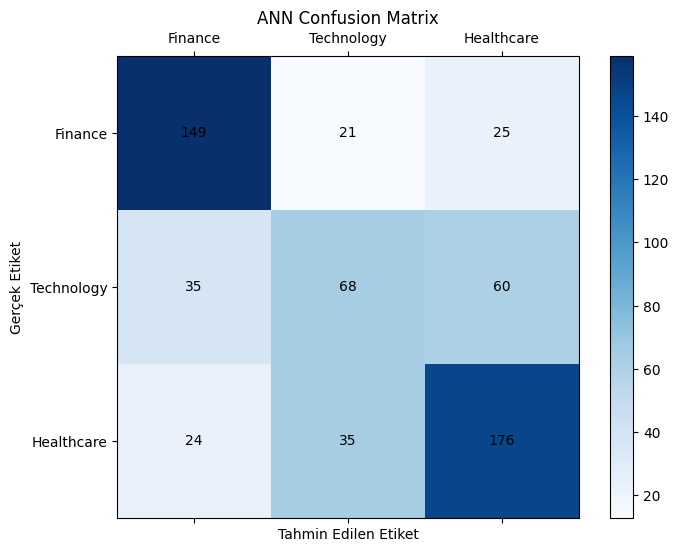

In [36]:
labels = ['Finance', 'Technology', 'Healthcare']

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(lstm_cm, cmap='Blues')

plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)


for i in range(len(labels)):
    for j in range(len(labels)):
        c = ann_cm[j, i]
        ax.text(i, j, str(c), va='center', ha='center')

plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('ANN Confusion Matrix')
plt.colorbar(cax)

plt.show()

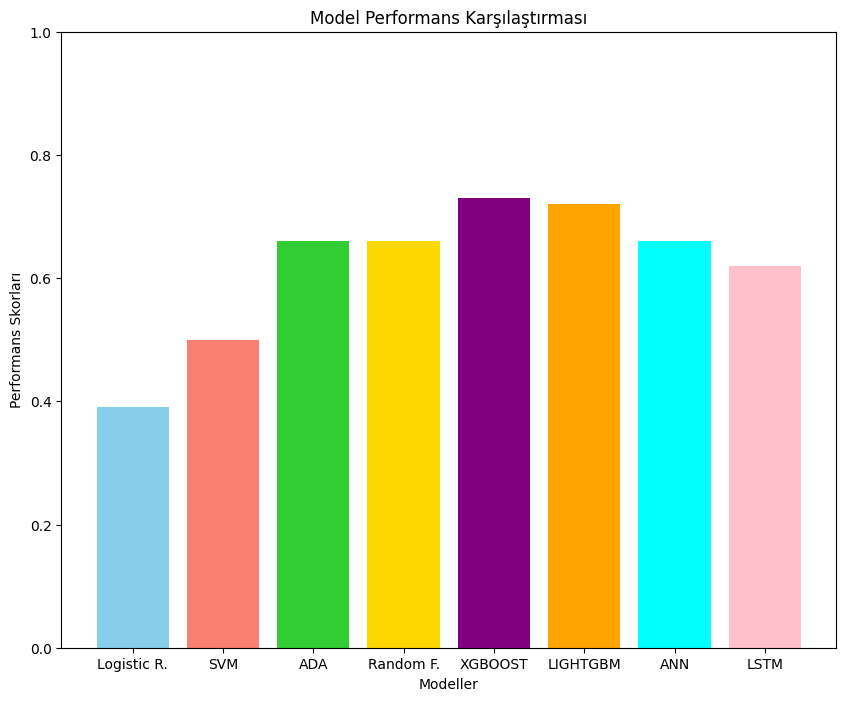

In [39]:
import matplotlib.pyplot as plt

models = ['Logistic R.', 'SVM', 'ADA', 'Random F.',
          'XGBOOST', 'LIGHTGBM', 'ANN', 'LSTM']
performance = [0.39, 0.50, 0.66, 0.66, 0.73, 0.72, 0.66, 0.62]
colors = ['skyblue', 'salmon', 'limegreen',
          'gold', 'purple', 'orange', 'cyan', 'pink']

plt.figure(figsize=(10, 8))
plt.bar(models, performance, color=colors)

plt.xlabel('Modeller')
plt.ylabel('Performans Skorları')
plt.title('Model Performans Karşılaştırması')
plt.ylim(0, 1)
plt.show()